# Capstone Project - The Battle of the Neighborhoods in Toronto, Canada

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)


## Introduction: Business Problem <a name="introduction"></a>

There are many things to consider when starting a food business. Although there are more, we can say the main ones are items such as financing, location, theme and menu. To begin with, it can be easily said that location is one of the most important of these. In this project we will try to help find the best location for a food business.

There are some factors to consider to find the best location. We can list them as follows: demography, labor costs and minimum wage, access, proximity to suppliers, competition, visibility, future growth, health regulations and zoning, security / crime rates.

This report will focus specifically on the competitive factor. Being too close to established competition can be a double-edged sword. To put it simply, being close to your competitors can help commercial marketing, but if you are too close to the competition, you may have a hard time gaining a foothold in the community.

Finally, this report will specifically target stakeholders who want to open a food venue in Toronto, Canada. Since there are many food venues in Toronto, we will do our work based on the neighborhoods to make it more understandable. Our aim here is to reveal the most or the least amount of food venues in the neighborhoods. And also to provide alternative options to stakeholders by grouping similar neighborhoods.

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decision are:
* number of existing food venues in the neighborhood (any type of food venue)
* The most common food venues in the neighborhood

Following data sources will be needed to extract/generate the required information:
* Information such as the postal code, borough, and neighborhood of the city of Toronto will be collected by scraping the <a href='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'>wikipedia</a> page.
* Toronto Neighborhood coordinates will be collected using the prepared geospatial data csv file.
* The latitude and longitude values of the city of Toronto will be collected using the geopy library.
* The number, type, location, postal code and distance of the food venues in each neighborhood will be obtained using the Foursquare API.

#### Firstly let's download and import the necessary libraries that we will use.

In [76]:
#download the geocoding library
!pip install geocoder
#download the folium library to visualize geospatial data
!pip install folium

In [77]:
# this module helps in web scrapping.
from bs4 import BeautifulSoup 
# this module helps us to download a web page
import requests

#for data manipulation and analysis
import pandas as pd
#for computing data
import numpy as np

# import geocoder
import geocoder 
# map rendering library
import folium 

# convert an address into latitude and longitude values
from geopy.geocoders import Nominatim 

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

from folium import plugins
from folium.plugins import HeatMap

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

### Scraping the Wikipedia page

This <a href='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'>wikipedia</a> page contains an html table with data of postal codes of Toronto, Canada. Firstly we will get the contents of the webpage in text format and store in a variable called data. Then we will use  *BeautifulSoup* constructor to find the necessary html table in the web page.

In [78]:
#The below url contains an html table with data of postal codes of Canada: M.
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

In [79]:
# get the contents of the webpage in text format and store in a variable called data
data  = requests.get(url).text

In [80]:
#pass the data into the BeautifulSoup constructor
soup = BeautifulSoup(data,"html5lib")

In [81]:
#find a html table in the web page
table = soup.find('table') 

### Creating the Dataset

After finding the html table, we create the dataframe. As seen on the web page, there are 'Not assigned' values in the table. We extract these values while creating the dataframe. Also, we clear the symbols like '/, (,)' in the table. And finally, we correct the names of some boroughs that are incorrectly named. Thus, we obtain the dataframe formed in Postal Code, Borough, Neighborhood columns.

In [82]:
table_contents=[]
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['Postal Code'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

# print(table_contents)
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto',
                                             'Queen\'s Park':'Downtown Toronto',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto',
                                             'EtobicokeNorthwest':'Etobicoke','East YorkEast Toronto':'East York',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})


Check for duplicate rows based on Postal Code column

In [83]:
# Select all duplicate rows based on one column
duplicateRowsDF = df[df.duplicated(['Postal Code'])]
print("Duplicate Rows based on a single column are:", duplicateRowsDF, sep='\n')

Duplicate Rows based on a single column are:
Empty DataFrame
Columns: [Postal Code, Borough, Neighborhood]
Index: []


Let's examine the Dataframe that we created

In [84]:
df.head()

Postal Code           Borough                      Neighborhood
0         M3A        North York                         Parkwoods
1         M4A        North York                  Victoria Village
2         M5A  Downtown Toronto         Regent Park, Harbourfront
3         M6A        North York  Lawrence Manor, Lawrence Heights
4         M7A  Downtown Toronto     Ontario Provincial Government

In [85]:
df.shape

(103, 3)

### Get the coordinates of each neighborhood

Using the provided <a href="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv">Geospatial Coordinates</a> csv file we get the latitude and longitude values of each neigborhood. 

In [86]:
df_coordinates = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv')
#df_coordinates = pd.read_csv('https://cocl.us/Geospatial_data')
df_coordinates.head()

Postal Code   Latitude  Longitude
0         M1B  43.806686 -79.194353
1         M1C  43.784535 -79.160497
2         M1E  43.763573 -79.188711
3         M1G  43.770992 -79.216917
4         M1H  43.773136 -79.239476

Now that we have the coordinates of each neighborhood, we can create the data frame to work on. For this, we will use pandas' merge function. And we will use the *Postal Code* column to match the two tables.

In [87]:
merged_df = pd.merge(df,df_coordinates,on='Postal Code')
merged_df.head()

Postal Code           Borough  ...   Latitude  Longitude
0         M3A        North York  ...  43.753259 -79.329656
1         M4A        North York  ...  43.725882 -79.315572
2         M5A  Downtown Toronto  ...  43.654260 -79.360636
3         M6A        North York  ...  43.718518 -79.464763
4         M7A  Downtown Toronto  ...  43.662301 -79.389494

[5 rows x 5 columns]

We take out the neighborhoods that do not belong to the city of Toronto from the dataframe.



In [88]:
index = merged_df[merged_df['Borough'] == 'Mississauga'].index
merged_df.drop(index,axis=0,inplace=True)

Let's examine the merged dataframe.

In [89]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(merged_df['Borough'].unique()),
        len(merged_df['Neighborhood'].unique())
    )
)

The dataframe has 9 boroughs and 102 neighborhoods.


In [90]:
merged_df.head()

Postal Code           Borough  ...   Latitude  Longitude
0         M3A        North York  ...  43.753259 -79.329656
1         M4A        North York  ...  43.725882 -79.315572
2         M5A  Downtown Toronto  ...  43.654260 -79.360636
3         M6A        North York  ...  43.718518 -79.464763
4         M7A  Downtown Toronto  ...  43.662301 -79.389494

[5 rows x 5 columns]

### Explore the neighborhoods in Toronto

Let's visualize the data to better understand. We can use the geopy library to get Toronto's latitude and longitude values.

In [91]:
address = 'Toronto'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.



#### Create a map of Toronto with neighborhoods superimposed on top.


In [92]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(merged_df['Latitude'], merged_df['Longitude'], merged_df['Borough'], merged_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto


In [93]:
map_toronto.save("neighborhood.html")

### Foursquare

Now that we have coordinates of neighborhoods in Toronto, let's use Foursquare API to get info on food venues in each neighborhood.

We are interested in venues in 'food' category, like coffee shops, pizza places, bakeries etc. So we will include in our list only venues that are  in food category.

Food venues will be gathered based on the neighborhoods. We take the radius as 2000 so as not to overlook any food venue. Of course, this will have some side effects. For neighborhoods that are close to each other, some venues will overlap.We plan to solve this problem in the data preprocessing part.

Finally, to briefly mention, we extract the name, latitude and longitude, postal code and distance of the food venue from the json file we received using the foursquare api and collect it in a dataframe.

In [145]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '' # Foursquare API version
LIMIT = 1000 # A default Foursquare API limit value
CATEGORY = "4d4b7105d754a06374d81259"
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


In [95]:
def getNearbyVenues(postalcodes, boroughs, names, latitudes, longitudes, radius=2000):
    
    venues_list=[]
    for postalcode, borough, name, lat, lng in zip(postalcodes, boroughs, names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            CATEGORY, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            postalcode, 
            borough,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'], 
            v['venue']['location'].get('postalCode', ''),  
            v['venue']['location'].get('distance', ''),  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood Postal Code',
                  'Borough',
                  'Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Postal Code',
                  'Venue Distance',
                  'Venue Category']
    
    return(nearby_venues)

In [96]:
# get all venues
all_venues = getNearbyVenues(postalcodes=merged_df['Postal Code'], 
                             boroughs=merged_df['Borough'],
                             names=merged_df['Neighborhood'],
                             latitudes=merged_df['Latitude'],
                             longitudes=merged_df['Longitude']
                            )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Ontario Provincial Government
Islington Avenue
Malvern, Rouge
Don Mills North
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
The Danforth  East
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmount Park
Bayview Village
Downsview East
The Danforth

Let's examine the venues dataframe.



In [97]:
print('Shape of the dataframe : {}'.format(all_venues.shape))

Shape of the dataframe : (6967, 11)


In [98]:
all_venues.head()

Neighborhood Postal Code  ...             Venue Category
0                      M3A  ...       Caribbean Restaurant
1                      M3A  ...                       Café
2                      M3A  ...  Middle Eastern Restaurant
3                      M3A  ...       Caribbean Restaurant
4                      M3A  ...   Mediterranean Restaurant

[5 rows x 11 columns]

Looking good. So now we have all the food venues in the city of Toronto. We also know which food venues exactly are in vicinity of every neighborhood

This concludes the data gathering phase - we're now ready to use this data for analysis to produce the report on starting point location for a new food venue.

## Methodology <a name="methodology"></a>

In this project, we will direct our work to determine the density of food venues in Toronto's neighborhoods and the type of food venues that are the most common in the neighborhoods.

In first step we have collected the required data: name, location,  category, postal code and distance of every food venue in the city of Toronto. 

The second step in our analysis will be to prepare the data set we created using the Foursquare api for analysis. This will be done by organizing venues that are overlapped or unclear to which neighborhood they belong to. Then, necessary actions will be taken to find the 'food venue density' and the 'frequency of similar food venues'.

In the third and final step, we will present a heatmap to show the density of neighborhoods in terms of food venues and focus on what implications these can have for stakeholders. In addition, we will provide basic information to the stakeholders by considering the most common types of food venues in these neighborhoods. This will allow stakeholders to choose a starting point at the neighborhood level. And finally, we will create clustering (using k-means clustering) to offer stakeholders different alternatives in terms of neighborhood.

## Analysis <a name="analysis"></a>

As seen in the table, the venue postal code is given in more detail than the neighborhood postal code. Since we will make matches using postal codes, we first make them the same type.

In [99]:
for index in range(len(all_venues.loc[:, 'Venue Postal Code'])):
  all_venues.loc[index, 'Venue Postal Code'] = all_venues.loc[index, 'Venue Postal Code'][0:3]

Afterwards, we compare postal codes and mark which venue is located in the right neighborhood or not. The point we should consider here is that some venues do not have postal codes. We mark them as unknown for now.

In [100]:
def checkPostalCodes(row):
    if row['Neighborhood Postal Code'] == row['Venue Postal Code']:
        val = True
    elif row['Venue Postal Code'] == '':
        val = 'Unknown'
    else:
        val = False
    return val

all_venues['Flag'] = all_venues.apply(checkPostalCodes, axis=1)
all_venues.head()

Neighborhood Postal Code     Borough  ...             Venue Category     Flag
0                      M3A  North York  ...       Caribbean Restaurant     True
1                      M3A  North York  ...                       Café     True
2                      M3A  North York  ...  Middle Eastern Restaurant    False
3                      M3A  North York  ...       Caribbean Restaurant  Unknown
4                      M3A  North York  ...   Mediterranean Restaurant    False

[5 rows x 12 columns]

Let's examine the flags.

In [101]:
all_venues['Flag'].value_counts()

False      3433
Unknown    1869
True       1665
Name: Flag, dtype: int64

Let's divide and examine the dataframe according to the flag column.

In [102]:
# splitting dataframe by groups
# grouping by flag column
grouped = all_venues.groupby(all_venues.Flag)
true_venues = grouped.get_group(True)
false_venues = grouped.get_group(False)
unknown_venues = grouped.get_group('Unknown')

print('Shape of the true_venues dataframe    : {}'.format(true_venues.shape))
print('Shape of the false_venues dataframe   : {}'.format(false_venues.shape))
print('Shape of the unknown_venues dataframe : {}'.format(unknown_venues.shape))

Shape of the true_venues dataframe    : (1665, 12)
Shape of the false_venues dataframe   : (3433, 12)
Shape of the unknown_venues dataframe : (1869, 12)


First, let's examine the dataframe that we marked as false. The reason we marked it as false here is because these venues overlap. This is due to the fact that we take the radius as 2000 while using the Foursquare API.

The first thing we need to pay attention to here is whether the venues we marked as false are within the true dataframe or not. So here we are trying to understand that all venues marked as false are overlapping venues or are there some exceptions.

In [103]:
false_venues = false_venues.reset_index(drop=True)

def checkForDuplicates(row):
    a = true_venues[(true_venues['Venue Latitude'] == row['Venue Latitude']) 
                    & (true_venues['Venue Longitude'] == row['Venue Longitude']) 
                    & (true_venues['Venue'] == row['Venue'])]
    if a.empty:
        val = 'No'
    else:
        val = 'Yes'
    return val

false_venues['Delete'] = false_venues.apply(checkForDuplicates, axis=1)
false_venues.head()

Neighborhood Postal Code     Borough  ...   Flag  Delete
0                      M3A  North York  ...  False     Yes
1                      M3A  North York  ...  False     Yes
2                      M3A  North York  ...  False     Yes
3                      M3A  North York  ...  False     Yes
4                      M3A  North York  ...  False     Yes

[5 rows x 13 columns]

As can be seen from the total numbers, although most venues overlap, there are some exceptions in between.

In [104]:
false_venues['Delete'].value_counts()

Yes    2497
No      936
Name: Delete, dtype: int64

Let's remove the overlapping venues

In [105]:
false_venues = false_venues.reset_index(drop=True)
# Filter all rows for delete = yes
index = false_venues[false_venues['Delete'] == 'Yes'].index
false_venues.drop(index, inplace = True)
false_venues.head()

Neighborhood Postal Code     Borough  ...   Flag  Delete
9                       M3A  North York  ...  False      No
29                      M3A  North York  ...  False      No
34                      M3A  North York  ...  False      No
35                      M3A  North York  ...  False      No
48                      M4A  North York  ...  False      No

[5 rows x 13 columns]

We use the postal code to match the remaining venues with the neighborhoods. For this, we first check whether all postal codes belong to the neighborhoods of the city of Toronto. Then we delete the venues we marked as not belong and match the rest.

In [106]:
false_venues = false_venues.reset_index(drop=True)
def checkForPostalCodes(row):
    postalcode = row['Venue Postal Code']
    b = merged_df[merged_df['Postal Code'] == postalcode ]
    if b.empty:
        val = 'No'
    else:
        val = 'Yes'
    return val

false_venues['Exists'] = false_venues.apply(checkForPostalCodes, axis=1)
false_venues['Exists'].value_counts()

Yes    837
No      99
Name: Exists, dtype: int64

In [107]:
# Filter all rows for delete = yes
index = false_venues[false_venues['Exists'] == 'No'].index
false_venues.drop(index, inplace = True)

In [108]:
false_venues['Exists'].value_counts()

Yes    837
Name: Exists, dtype: int64

In [109]:
# Remove the columns that we dont need
false_venues.drop(['Neighborhood Postal Code', 'Borough',	'Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Flag', 'Delete', 'Exists'], axis = 1, inplace=True)
false_venues.head()

Venue  ...             Venue Category
1                Villa Madina  ...                 Restaurant
2           Surati Sweet Mart  ...          Indian Restaurant
3          Le Cafe Restaurant  ...          French Restaurant
4                      Subway  ...             Sandwich Place
5  The Prince - Shisha Lounge  ...  Middle Eastern Restaurant

[5 rows x 6 columns]

In [110]:
false_venues = false_venues.reset_index(drop=True)
false_venues = false_venues.rename(columns={'Venue Postal Code': 'Postal Code'})
false_venues.head()

Venue  ...             Venue Category
0                Villa Madina  ...                 Restaurant
1           Surati Sweet Mart  ...          Indian Restaurant
2          Le Cafe Restaurant  ...          French Restaurant
3                      Subway  ...             Sandwich Place
4  The Prince - Shisha Lounge  ...  Middle Eastern Restaurant

[5 rows x 6 columns]

In [111]:
new_false = pd.merge(merged_df,false_venues,on='Postal Code')
new_false.head()

Postal Code           Borough  ... Venue Distance  Venue Category
0         M5A  Downtown Toronto  ...           1026            Café
1         M5A  Downtown Toronto  ...            833  Sandwich Place
2         M5A  Downtown Toronto  ...           1197          Bistro
3         M5A  Downtown Toronto  ...            888           Diner
4         M5A  Downtown Toronto  ...           1174  Breakfast Spot

[5 rows x 10 columns]

In [112]:
new_false['Venue Postal Code'] = new_false['Postal Code']

Let's examine the final version of the dataframe that we split as false.

In [113]:
new_false = new_false.rename(columns={'Postal Code': 'Neighborhood Postal Code', 'Latitude': 'Neighborhood Latitude', 'Longitude': 'Neighborhood Longitude'})
new_false = new_false[[ 'Neighborhood Postal Code',
                        'Borough',
                        'Neighborhood',
                        'Neighborhood Latitude',
                        'Neighborhood Longitude',
                        'Venue',
                        'Venue Latitude',
                        'Venue Longitude',
                        'Venue Postal Code',
                        'Venue Distance',
                        'Venue Category',
                        ]]
new_false.head()

Neighborhood Postal Code           Borough  ... Venue Distance  Venue Category
0                      M5A  Downtown Toronto  ...           1026            Café
1                      M5A  Downtown Toronto  ...            833  Sandwich Place
2                      M5A  Downtown Toronto  ...           1197          Bistro
3                      M5A  Downtown Toronto  ...            888           Diner
4                      M5A  Downtown Toronto  ...           1174  Breakfast Spot

[5 rows x 11 columns]

As we did in the previous step, we first check whether the places we marked as unknown are within the real data frame.

In [114]:
unknown_venues = unknown_venues.reset_index(drop=True)
def checkForDuplicates(row):
    a = true_venues[(true_venues['Venue Latitude'] == row['Venue Latitude']) 
                    & (true_venues['Venue Longitude'] == row['Venue Longitude']) 
                    & (true_venues['Venue'] == row['Venue'])]
    if a.empty:
        val = 'No'
    else:
        val = 'Yes'
    return val

unknown_venues['Delete'] = unknown_venues.apply(checkForDuplicates, axis=1)
unknown_venues.head()

Neighborhood Postal Code     Borough  ...     Flag  Delete
0                      M3A  North York  ...  Unknown      No
1                      M3A  North York  ...  Unknown      No
2                      M3A  North York  ...  Unknown      No
3                      M3A  North York  ...  Unknown      No
4                      M3A  North York  ...  Unknown      No

[5 rows x 13 columns]

In [115]:
unknown_venues['Delete'].value_counts()

No    1869
Name: Delete, dtype: int64

If there is more than one of the same venue, the distance value will be used to find out which neighborhood the venue is close to and be matched.

In [116]:
grouped = unknown_venues.groupby(['Venue', 'Venue Latitude', 'Venue Longitude'])    
dataframes = [grouped.get_group(x) for x in grouped.groups]#list of DataFrames
index_list = []
for dataframe in dataframes:
  index_list.append(dataframe['Venue Distance'].idxmin())


In [117]:
new_unknown = unknown_venues.iloc[index_list]
new_unknown.head()


Neighborhood Postal Code       Borough  ...     Flag  Delete
1755                      M8X     Etobicoke  ...  Unknown      No
221                       M4C     East York  ...  Unknown      No
560                       M2J    North York  ...  Unknown      No
589                       M3J    North York  ...  Unknown      No
712                       M4K  East Toronto  ...  Unknown      No

[5 rows x 13 columns]

Yes, now that all our dataframes are ready, we are preparing the dataframes for concatenation.

In [118]:
new_unknown = new_unknown.reset_index(drop=True)
new_unknown['Venue Postal Code'] = new_unknown['Neighborhood Postal Code']
new_unknown.drop(['Flag', 'Delete'], axis = 1, inplace=True)
new_unknown.head()

Neighborhood Postal Code       Borough  ... Venue Distance      Venue Category
0                      M8X     Etobicoke  ...           1638         Pizza Place
1                      M4C     East York  ...           1282         Pizza Place
2                      M2J    North York  ...           1593         Pizza Place
3                      M3J    North York  ...           1032         Pizza Place
4                      M4K  East Toronto  ...            311  Italian Restaurant

[5 rows x 11 columns]

In [119]:
new_false.head()

Neighborhood Postal Code           Borough  ... Venue Distance  Venue Category
0                      M5A  Downtown Toronto  ...           1026            Café
1                      M5A  Downtown Toronto  ...            833  Sandwich Place
2                      M5A  Downtown Toronto  ...           1197          Bistro
3                      M5A  Downtown Toronto  ...            888           Diner
4                      M5A  Downtown Toronto  ...           1174  Breakfast Spot

[5 rows x 11 columns]

In [120]:
# Remove the columns that we dont need
true_venues = true_venues.reset_index(drop=True)
true_venues.drop(['Flag'], axis = 1, inplace=True)
true_venues.head()

Neighborhood Postal Code     Borough  ... Venue Distance        Venue Category
0                      M3A  North York  ...            833  Caribbean Restaurant
1                      M3A  North York  ...            866                  Café
2                      M3A  North York  ...            852  Fast Food Restaurant
3                      M3A  North York  ...            967     Fish & Chips Shop
4                      M3A  North York  ...            839           Pizza Place

[5 rows x 11 columns]

Let's examine the final versions of the dataframes.

In [121]:
print('Shape of the true_venues dataframe : {}'.format(true_venues.shape))
print('Shape of the new_false dataframe   : {}'.format(new_false.shape))
print('Shape of the new_unknown dataframe : {}'.format(new_unknown.shape))

Shape of the true_venues dataframe : (1665, 11)
Shape of the new_false dataframe   : (837, 11)
Shape of the new_unknown dataframe : (952, 11)


Now we are ready to concatenation.

In [122]:
new_venues = pd.concat([true_venues, new_false, new_unknown], ignore_index=True)
print(new_venues.shape)
new_venues.head()

(3454, 11)


Neighborhood Postal Code     Borough  ... Venue Distance        Venue Category
0                      M3A  North York  ...            833  Caribbean Restaurant
1                      M3A  North York  ...            866                  Café
2                      M3A  North York  ...            852  Fast Food Restaurant
3                      M3A  North York  ...            967     Fish & Chips Shop
4                      M3A  North York  ...            839           Pizza Place

[5 rows x 11 columns]

Let's create a map showing the heat map / density of food venues and try to extract meaningful information from it. Also let's show the neighborhoods on our map for comparisons.

In [123]:
venues_latlons = []
for lat, lon in zip(new_venues['Venue Latitude'], new_venues['Venue Longitude']):
  latlon = [lat, lon]
  venues_latlons.append(latlon)

print(venues_latlons[1])

[43.76066827030228, -79.32636763515987]


In [124]:
address = 'Toronto'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [125]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)
folium.TileLayer('cartodbpositron').add_to(map_toronto) #cartodbpositron cartodbdark_matter
for lat, lon, neighborhood, borough in zip(new_venues['Neighborhood Latitude'], new_venues['Neighborhood Longitude'],  new_venues['Neighborhood'], new_venues['Borough']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=4,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=1,
        parse_html=False).add_to(map_toronto)
HeatMap(venues_latlons).add_to(map_toronto)

map_toronto

As you can see, our map is very hot, especially the neighborhoods connected to Downtown Toronto, Central Toronto, West Toronto and East Toronto are on fire. As can be understood from here, these areas are very valuable places for food venues.

In [126]:
map_toronto.save("density.html")

Let's check how many venues we have for each neighborhood

In [127]:
new_venues.groupby('Neighborhood').count().sort_values(by=['Venue Category'], ascending=False).head()

Neighborhood Postal Code  ...  Venue Category
Neighborhood                                                                  ...                
CN Tower, King and Spadina, Railway Lands, Harb...                       177  ...             177
Regent Park, Harbourfront                                                 97  ...              97
Milliken, Agincourt North, Steeles East, L'Amor...                        86  ...              86
Dorset Park, Wexford Heights, Scarborough Town ...                        75  ...              75
Studio District                                                           74  ...              74

[5 rows x 10 columns]

Let's analyze each neighborhood

In [128]:
# one hot encoding
toronto_onehot = pd.get_dummies(new_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = new_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

Neighborhood  Afghan Restaurant  ...  Wings Joint  Xinjiang Restaurant
0    Parkwoods                  0  ...            0                    0
1    Parkwoods                  0  ...            0                    0
2    Parkwoods                  0  ...            0                    0
3    Parkwoods                  0  ...            0                    0
4    Parkwoods                  0  ...            0                    0

[5 rows x 114 columns]

In [129]:
toronto_onehot.shape

(3454, 114)

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [130]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

Neighborhood  ...  Xinjiang Restaurant
0                                        Agincourt  ...                  0.0
1                           Alderwood, Long Branch  ...                  0.0
2  Bathurst Manor, Wilson Heights, Downsview North  ...                  0.0
3                                  Bayview Village  ...                  0.0
4                Bedford Park, Lawrence Manor East  ...                  0.0

[5 rows x 114 columns]

In [131]:
toronto_grouped.shape

(101, 114)

First, let's write a function to sort the venues in descending order.


In [132]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.


In [133]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood  ...    10th Most Common Venue
0                                        Agincourt  ...            Breakfast Spot
1                           Alderwood, Long Branch  ...                Donut Shop
2  Bathurst Manor, Wilson Heights, Downsview North  ...  Mediterranean Restaurant
3                                  Bayview Village  ...      Fast Food Restaurant
4                Bedford Park, Lawrence Manor East  ...          Greek Restaurant

[5 rows x 11 columns]

In [134]:
index = 'CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport'
temp = toronto_grouped.set_index('Neighborhood')
temp = temp[temp.index == index]
temp.head()

Afghan Restaurant  ...  Xinjiang Restaurant
Neighborhood                                                           ...                     
CN Tower, King and Spadina, Railway Lands, Harb...                0.0  ...                  0.0

[1 rows x 113 columns]

In [135]:
temp = temp.loc[:, (temp != 0.0).any(axis=0)]
temp.head()

American Restaurant  ...  Wings Joint
Neighborhood                                                             ...             
CN Tower, King and Spadina, Railway Lands, Harb...              0.00565  ...      0.00565

[1 rows x 29 columns]

Text(0, 0.5, 'Venue Category')

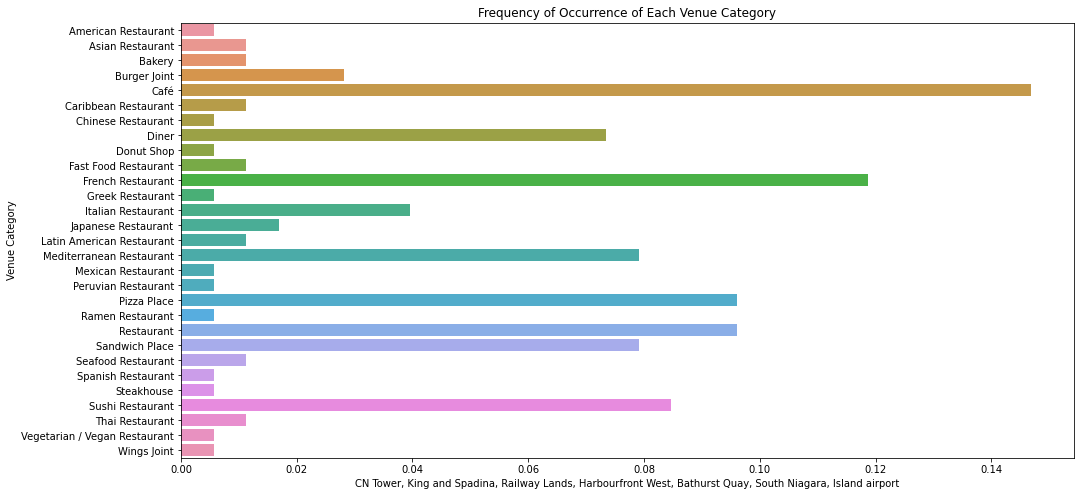

In [136]:
# Set the width and height of the figure
plt.figure(figsize=(16,8))

# Add title
plt.title("Frequency of Occurrence of Each Venue Category")

# Bar chart showing Frequency of Occurrence of Each Venue Category
sns.barplot(x=temp.iloc[0], y=temp.columns)

# Add label for vertical axis
plt.ylabel("Venue Category")

The CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport neighborhoods are the first area with the most venues. As seen in the graph, the most common types of food venues in this region are Cafes, French Restaurants, gastropubs, Pizza places and Restaurants. Although this region is very valuable for food venues, it may not be a good idea for a new business to open one of these types of venues, which are already in large numbers here

### Cluster Neighborhoods

Now let's cluster neighborhoods together to see similar neighborhoods. This will enable us to offer stakeholders different neighborhoods as an alternative.

For this, let's first prepare our dataframe.

In [137]:
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
toronto_grouped_clustering.head()

Afghan Restaurant  African Restaurant  ...  Wings Joint  Xinjiang Restaurant
0                0.0                 0.0  ...     0.000000                  0.0
1                0.0                 0.0  ...     0.032258                  0.0
2                0.0                 0.0  ...     0.000000                  0.0
3                0.0                 0.0  ...     0.034483                  0.0
4                0.0                 0.0  ...     0.030303                  0.0

[5 rows x 113 columns]

In [138]:
# set number of clusters
kclusters = 7

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0, n_init=50).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 2, 2, 6, 2, 6, 2, 6, 6, 6], dtype=int32)

Let's check the number of neighborhoods

In [139]:
print('The dataframe has {} neighborhoods.'.format(
        len(toronto_grouped['Neighborhood'].unique())
    )
)


The dataframe has 101 neighborhoods.


It looks like we have a lost neighborhood. To make the dataframe more useful, we need to remove the missing neighborhood.

In [140]:
neigh = []
index_list = merged_df['Neighborhood'].tolist()
for ind in index_list:
    b = toronto_grouped[toronto_grouped['Neighborhood'] == ind ]
    if b.empty:
        neigh.append(ind)

print(neigh)

['Ontario Provincial Government']


In [141]:
merged_data = merged_df.drop('Postal Code', 1)
index = merged_data[merged_data['Neighborhood'] == 'Ontario Provincial Government'].index
merged_data.drop(index,axis=0,inplace=True)
merged_data.head()

Borough                      Neighborhood   Latitude  Longitude
0        North York                         Parkwoods  43.753259 -79.329656
1        North York                  Victoria Village  43.725882 -79.315572
2  Downtown Toronto         Regent Park, Harbourfront  43.654260 -79.360636
3        North York  Lawrence Manor, Lawrence Heights  43.718518 -79.464763
5         Etobicoke                  Islington Avenue  43.667856 -79.532242

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.


In [142]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = merged_data

toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head()

Borough  ... 10th Most Common Venue
0        North York  ...                  Diner
1        North York  ...    American Restaurant
2  Downtown Toronto  ...      French Restaurant
3        North York  ...            Pizza Place
5         Etobicoke  ...         Sandwich Place

[5 rows x 15 columns]

Finally, let's visualize the resulting clusters


In [143]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

We've finally finished clustering the neighborhoods. So we found out which neighborhoods were similar. In this way, we offered different alternatives to stakeholders.

In [144]:
map_clusters.save("cluster.html")

## Results and Discussion <a name="results"></a>

Our analysis shows that the busiest area in the city of Toronto in terms of food venues is the neighborhoods connected to the Downtown Toronto borough. The main ones are CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport neighborhoods. Only from this analysis can we understand that this area is a valuable area for food venues. However, there are many things to consider when choosing a place for the food venue. Although this area is a valuable place, it may not be a good choice for some food venues.

Of course, there are many factors to consider when choosing a food venue location, but here we focus only on the 'competition' factor. In order to evaluate this factor, we presented the neighborhood-based venues we collected and how often they were in which neighborhood as a result of our analysis. For example, although the area consisting of CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport neighborhoods seems like an attractive location, it may not be a good idea for venues like Cafe or French Restaurant here. If we are looking for a venue in this style, we can also consider the following areas.

Finally, the fact that this study is not inclusive may reveal some drawbacks. One of them is that the information we provide is far from offering pinpoint options for stakeholders. The reason for this is that our analyzes are far from the real field. Therefore, it should not be forgotten that the information we provide will only help stakeholders to choose a starting point in finding a new location for their business.

## Conclusion <a name="conclusion"></a>

The aim of this project was to assist stakeholders trying to find venues for a food venue in the city of Toronto. There are many factors that affect the location of a food venue. In this study, analyzes were made considering only the competition factor. First of all, all venues in the food category were collected on the basis of Neighborhoood using the Foursquare api. As a result of the analysis made afterwards, the density of food venues in the city was revealed. Thus, the competition factor at the general level was examined. Then, going a little more specific, the frequency of food venues in the neighborhoods was revealed as a result of analysis. Thus, stakeholders will be able to easily select a starting point by taking this information into consideration during the location selection phase.

Finally, it should be noted that the stakeholders should pay attention to all factors when choosing the location for the food venue. We can list these factors as follows: demography, labor costs and minimum wage, access, proximity to suppliers, competition, visibility, future growth, health regulations and zoning, security / crime rates. When the stakeholders consider all these factors, they will be able to choose the best location for their food venues.